In [12]:
from transformers import AutoModelForCausalLM, AutoTokenizer, GPT2Model
import torch
from torch import tensor

from sklearn.neighbors import NearestNeighbors

import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from dadapy import id_estimation, Data
from sklearn.metrics.pairwise import cosine_similarity

In [13]:
# Define the model and the tokenizer
model = GPT2Model.from_pretrained("openai-community/gpt2")
tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
model.eval()

GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D(nf=2304, nx=768)
        (c_proj): Conv1D(nf=768, nx=768)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D(nf=3072, nx=768)
        (c_proj): Conv1D(nf=768, nx=3072)
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [14]:
#prompt = "In the year 2132, Earth is no longer the only home of humanity. After decades of exploration and colonization, humans have established settlements on Mars, several moons of Jupiter and Saturn, and even a floating city in the clouds of Venus. Technology has progressed to the point where artificial intelligence governs most civil operations, and the line between human and machine is blurrier than ever. Your protagonist, Kaelen Rho, is a hybrid—half-human, half-synthetic—created as part of a secret program to engineer beings capable of thriving in extreme environments. Kaelen has no memory of their early years, only fragments of coded dreams and flickers of forgotten voices. Raised on Titan by a collective of AI guardians, Kaelen has always known they were different, but the truth of their origin was kept hidden… until now. Following a sudden system failure that disables a critical communication relay between the outer colonies, Kaelen discovers a buried transmission hidden in the data logs—one that includes a name they've never heard but somehow recognize: Dr. Alira Voss. The message is heavily encrypted, but it’s clear the sender wanted Kaelen to find it. The message references something called “The Core Directive”—a protocol that, if activated, could permanently sever AI from human control or merge their consciousness into a shared network, forever altering the fabric of identity. Haunted by questions and pursued by unknown forces—both human and machine—Kaelen must leave the only home they’ve known and begin a journey across the solar system to uncover the truth about their creation, the nature of The Core Directive, and their role in an impending civil war that will force humanity to choose: evolution or extinction."
prompt = "Only the sky is the"
inputs = tokenizer(prompt, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs, output_hidden_states=True)

# Access model configuration
hidden_size = model.config.n_embd         # 768 
num_heads = model.config.n_head           # 12 
num_layers = len(model.h)                 # 12 
head_dim = hidden_size // num_heads       # 64

In [15]:
def QKV_spaces(model, inputs, block_idx):
    """
    Function to extract the Q, K and V matrices
    model: model we want to study
    inputs: input prompt
    block_idx: index of the decoder block
    """

    # Access a specific attention block
    attention_block = model.h[block_idx].attn

    # Extract attention weights
    with torch.no_grad():
        hidden_states = model(inputs.input_ids)[0]

        Q, K, V = attention_block.c_attn(hidden_states).split(hidden_states.size(-1), dim=-1)
        
        # Reshape for multi-head attention
        batch_size, seq_length, hidden_size = hidden_states.shape
        head_dim = hidden_size // model.config.n_head
        
        Q = Q.view(batch_size, seq_length, model.config.n_head, head_dim)
        K = K.view(batch_size, seq_length, model.config.n_head, head_dim)
        V = V.view(batch_size, seq_length, model.config.n_head, head_dim)
        
        return Q, K, V 

In [16]:
def PCA_dim_reduction(M, threshold=0.9):
    """
    Computes the number of original dimensions needed to explain a given percentage 
    of variance for each attention head.

    Args:
        M (torch.Tensor): Tensor of shape (batch_size=1, tokens, heads, head_dim)
        threshold (float): Fraction of total variance to retain (e.g. 0.9)

    Returns:
        List[int]: Number of dimensions needed per head
    """
    assert M.dim() == 4, "Expected Q_tensor shape (1, tokens, heads, head_dim)"
    M = M.squeeze(0)  
    
    retained_dims_per_head = []

    # Loop over heads
    for head in range(M.shape[1]):  
        data = M[:, head, :]  # dim: (tokens, head_dim)

        variances = data.var(dim=0).numpy()
        sorted_vars = np.sort(variances)[::-1]

        cum_variance = np.cumsum(sorted_vars)
        total_variance = cum_variance[-1]
        cum_explained = cum_variance / total_variance

        num_dims = np.searchsorted(cum_explained, threshold) + 1
        retained_dims_per_head.append(num_dims)

    return retained_dims_per_head

In [ ]:
def compute_cosine_similarity(M, N):
    """
    Computes the number of original dimensions needed to explain a given percentage 
    of variance for each attention head.

    Args:
        M (torch.Tensor): Tensor of shape (batch_size=1, tokens, heads, head_dim)
        threshold (float): Fraction of total variance to retain (e.g. 0.9)

    Returns:
        List[int]: Cosine similarity
    """
    assert M.dim() == 4, "Expected Q_tensor shape (1, tokens, heads, head_dim)"
    M = M.squeeze(0)  

    assert N.dim() == 4, "Expected Q_tensor shape (1, tokens, heads, head_dim)"
    N = N.squeeze(0)  
    
    orientation_per_head = []

    # Loop over heads
    for head in range(M.shape[1]):  
        M1 = M[:, head, :]  # dim: (tokens, head_dim)
        M2 = M[:, head, :]

        orientation = cosine_similarity(M1, M2)
        orientation_per_head.append(orientation)

    return orientation_per_head

In [17]:
def plot_dims(dim_dict, which_matrix="dimQ"):
    """ 
    Plot the PCA intrinsic dimension per head across layers.

    Args:
        dim_dict: Dictionary with the Q, K, V spaces per layer and head
        which_matrix: One of "dimQ", "dimK", or "dimV"
        colormap_name: Name of the colormap to use (default: "viridis")
    """
    num_heads = 12
    layers = sorted(dim_dict.keys())

    # Spread the head indices evenly across the colormap (0 to 1)
    colormap_name="YlOrRd"
    cmap = plt.colormaps[colormap_name]
    color_positions = np.linspace(0.2, 1, num_heads)
    colors = [cmap(pos) for pos in color_positions]

    markers = ["^", "o", "s", "X", "v", ">", "<", "P", "D", "*", "+", "h"]
    linestyles = ["solid", "dotted", "dashed", "dashdot"] * 3

    for head_idx in range(num_heads):
        dims = [dim_dict[layer][which_matrix][head_idx] for layer in layers]
        color = colors[head_idx]
        marker = markers[head_idx % len(markers)]
        linestyle = linestyles[head_idx % len(linestyles)]

        plt.plot(layers, dims, marker=marker, linestyle=linestyle,
                 markersize=7, linewidth=2, label=head_idx,
                 color=color)

    plt.xlabel('Layer')
    plt.ylabel(which_matrix)
    plt.title(f"PCA Intrinsic Dimension per Head ({which_matrix})")
    plt.legend(loc='best', title="Heads", ncol=3)
    plt.grid(alpha=0.4)
    plt.tight_layout()
    plt.show()

In [23]:
# Def a dictionary to store the results
dimQKV_dict = {}

# Loop over each block
for block_idx in range(12):
    # Retrieve Q, K, V matrices
    Q, K, V = QKV_spaces(model, inputs, block_idx)

    # Compute the dimensionality for each of them
    dimQ = PCA_dim_reduction(Q)
    dimK = PCA_dim_reduction(K)
    dimV = PCA_dim_reduction(V)

    # Store everything in a dictionary
    dimQKV_dict[block_idx] = {
        "layer": block_idx,
        'dimQ': dimQ,
        'dimK': dimK,
        'dimV': dimV
    }
    
print(dimQKV_dict)

tensor([[[[ 11.4950,   9.7501,   9.8191,  ...,  -5.4930,   7.6334,  -2.0421],
          [ -7.3565, -23.0528,  10.6673,  ..., -12.2401,   3.9907, -12.3937],
          [ -3.9860,   2.5151,   6.2383,  ...,   9.9510,  14.9597,   1.1150],
          ...,
          [ -0.1451,  -1.9451,   4.0201,  ...,  14.0269,  -2.2701,   7.7141],
          [  1.7978,   3.3561,   1.8660,  ...,  -7.4625,   6.2647,  -6.3012],
          [  5.7253, -28.0691,  38.5398,  ...,  17.0685,  12.0011,  34.5366]],

         [[ 34.9039,  47.6973,  17.6594,  ...,  -8.5694,  16.3885,   2.4898],
          [ -3.1310, -79.6769,  28.4957,  ..., -41.0659,  37.1231, -27.6003],
          [-11.9231,   1.1127,  11.7784,  ...,  10.6100,  34.2882,  -6.4751],
          ...,
          [  1.7971,  -2.1899,   0.1357,  ...,  44.6166, -12.8435,  17.9955],
          [  1.3928,   7.5490,   5.4227,  ..., -20.8114,  17.1426, -19.4762],
          [  6.8837, -57.8621,  95.9827,  ...,  60.5400,  28.6893,  75.0850]],

         [[ 26.3256,  37.5469,

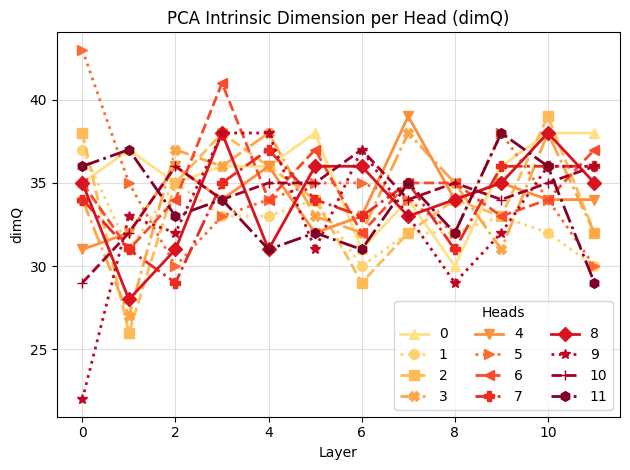

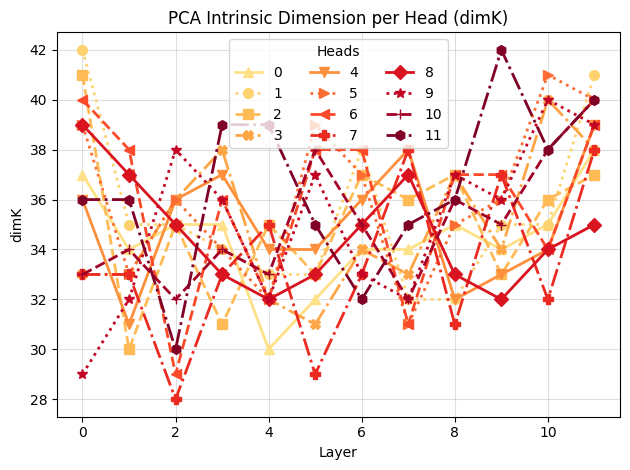

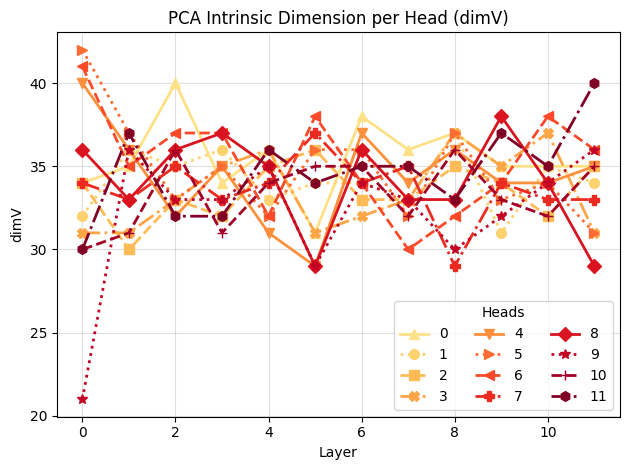

In [19]:
plot_dims(dimQKV_dict, "dimQ")
plot_dims(dimQKV_dict, "dimK")
plot_dims(dimQKV_dict, "dimV")

In [26]:
# Def a dictionary to store the results
cosine_similarity_dict = {}

# Loop over each block
for block_idx in range(12):
    # Retrieve Q, K, V matrices
    Q, K, V = QKV_spaces(model, inputs, block_idx)
    
    # Delete the first dimension
    Q = Q.squeeze(0)
    K = K.squeeze(0)
    V = V.squeeze(0)

    # Compute the dimensionality for each of them
    QK_orientation = cosine_similarity(Q, K)
    QV_orientation = cosine_similarity(Q, V)
    KV_orientation = cosine_similarity(K, V)

    # Store everything in a dictionary
    cosine_similarity_dict[block_idx] = {
        "layer": block_idx,
        'dimQ': dimQ,
        'dimK': dimK,
        'dimV': dimV
    }
    
print(dimQKV_dict)



torch.Size([5, 12, 64])


ValueError: Found array with dim 3. check_pairwise_arrays expected <= 2.

In [20]:
def format_id_value(id_value):
    """
    Helper function to safely format the ID value, whether it's a float, tuple, or other structure.
    """
    if id_value is None:
        return "N/A"
    elif isinstance(id_value, (float, int)):
        return f"{id_value:.2f}"
    elif isinstance(id_value, tuple) and len(id_value) > 0:
        # If it's a tuple, use the first value or format appropriately
        return f"{id_value[0]:.2f}"
    else:
        # For any other type, convert to string
        return str(id_value)

def analyze_qkv_orientations(model, inputs, num_blocks=12):
    """
    Analyze Q, K, V spaces orientation using cosine similarity after computing their intrinsic dimensionality.
    
    Args:
        model: The transformer model
        inputs: Input tensors
        num_blocks: Number of transformer blocks to analyze
    
    Returns:
        Dictionary with intrinsic dimensionality and similarity metrics
    """
    # Dictionary to store all results
    results = {}
    
    # For storing average cosine similarities across layers
    qk_sims = []
    qv_sims = []
    kv_sims = []
    
    # Loop over each block
    for block_idx in range(num_blocks):        
        # Retrieve Q, K, V matrices
        Q, K, V = QKV_spaces(model, inputs, block_idx)
        
        # Reshape to 2D: combine all dimensions except the last
        # From [1, 13, 12, 64] to [1*13*12, 64]
        Q_reshaped = Q.reshape(-1, Q.shape[-1])
        K_reshaped = K.reshape(-1, K.shape[-1])
        V_reshaped = V.reshape(-1, V.shape[-1])
                
        # Convert to NumPy for dimensionality calculation
        Q_numpy = Q_reshaped.detach().cpu().numpy()
        K_numpy = K_reshaped.detach().cpu().numpy()
        V_numpy = V_reshaped.detach().cpu().numpy()
        
        # Compute intrinsic dimensionality
        ieQ = Data(coordinates=Q_numpy)
        ieK = Data(coordinates=K_numpy)
        ieV = Data(coordinates=V_numpy)
        
        try:
            dimQ = ieQ.compute_id_2NN()
            dimK = ieK.compute_id_2NN() 
            dimV = ieV.compute_id_2NN()
            
            # Store the raw values
            dimQ_raw = dimQ
            dimK_raw = dimK
            dimV_raw = dimV
            
            # Extract numeric values if they're tuples or complex objects
            if isinstance(dimQ, tuple) and len(dimQ) > 0:
                dimQ = dimQ[0]  # Use first value if it's a tuple
            if isinstance(dimK, tuple) and len(dimK) > 0:
                dimK = dimK[0]
            if isinstance(dimV, tuple) and len(dimV) > 0:
                dimV = dimV[0]
                
            # Convert to float if possible
            try:
                dimQ = float(dimQ)
                dimK = float(dimK)
                dimV = float(dimV)
            except (TypeError, ValueError):
                # If conversion fails, use None
                print(f"Warning: Could not convert dimensionality values to float.")
                dimQ = dimK = dimV = None
                
        except Exception as e:
            print(f"Error computing intrinsic dimensionality: {e}")
            dimQ = dimK = dimV = None
            dimQ_raw = dimK_raw = dimV_raw = None
        
        # Calculate representation orientation (cosine similarities)
        try:
            # 1. Between individual vectors within each space
            # Get pairwise cosine similarities within each representation space
            print(np.shape(Q_numpy))
            Q_sim_matrix = cosine_similarity(Q_numpy)
            K_sim_matrix = cosine_similarity(K_numpy)
            V_sim_matrix = cosine_similarity(V_numpy)
            
            # Calculate average similarity (excluding self-similarity on diagonal)
            n = Q_sim_matrix.shape[0]
            Q_avg_sim = (Q_sim_matrix.sum() - n) / (n*n - n)  # Exclude diagonal
            K_avg_sim = (K_sim_matrix.sum() - n) / (n*n - n)
            V_avg_sim = (V_sim_matrix.sum() - n) / (n*n - n)
            
            # 2. Between corresponding vectors across spaces
            # Compare alignment of each query vector with its corresponding key and value vectors
            QK_cosine = np.mean([np.dot(Q_numpy[i], K_numpy[i]) / 
                              (np.linalg.norm(Q_numpy[i]) * np.linalg.norm(K_numpy[i]) + 1e-8) 
                              for i in range(len(Q_numpy))])
            
            QV_cosine = np.mean([np.dot(Q_numpy[i], V_numpy[i]) / 
                              (np.linalg.norm(Q_numpy[i]) * np.linalg.norm(V_numpy[i]) + 1e-8) 
                              for i in range(len(Q_numpy))])
            
            KV_cosine = np.mean([np.dot(K_numpy[i], V_numpy[i]) / 
                              (np.linalg.norm(K_numpy[i]) * np.linalg.norm(V_numpy[i]) + 1e-8) 
                              for i in range(len(K_numpy))])
            
            # Store for later visualization
            qk_sims.append(QK_cosine)
            qv_sims.append(QV_cosine)
            kv_sims.append(KV_cosine)
            
        except Exception as e:
            print(f"Error computing cosine similarities: {e}")
            Q_avg_sim = K_avg_sim = V_avg_sim = None
            QK_cosine = QV_cosine = KV_cosine = None
        
        # Store all results for this block
        results[block_idx] = {
            "layer": block_idx,
            # Intrinsic dimensionality - both raw and processed values
            'dimQ': dimQ,
            'dimK': dimK,
            'dimV': dimV,
            'dimQ_raw': dimQ_raw,
            'dimK_raw': dimK_raw,
            'dimV_raw': dimV_raw,
            # Within-space average similarity
            'Q_internal_sim': Q_avg_sim,
            'K_internal_sim': K_avg_sim,
            'V_internal_sim': V_avg_sim,
            # Cross-space alignment
            'QK_alignment': QK_cosine,
            'QV_alignment': QV_cosine,
            'KV_alignment': KV_cosine
        }
    
    return results

results = analyze_qkv_orientations(model, inputs)
print(results)

(60, 64)
(60, 64)
(60, 64)
(60, 64)
(60, 64)
(60, 64)
(60, 64)
(60, 64)
(60, 64)
(60, 64)
(60, 64)
(60, 64)
{0: {'layer': 0, 'dimQ': 4.862361726656654, 'dimK': 5.447709723654191, 'dimV': 4.1287343055718155, 'dimQ_raw': (4.862361726656654, 0.0, 62.928479129346364), 'dimK_raw': (5.447709723654191, 0.0, 114.94142213973055), 'dimV_raw': (4.1287343055718155, 0.0, 19.231717355936212), 'Q_internal_sim': 0.06072051484706038, 'K_internal_sim': 0.06879667292880473, 'V_internal_sim': 0.057015801553672314, 'QK_alignment': 0.27516981810448216, 'QV_alignment': 0.00021675227136217222, 'KV_alignment': -0.024262160168523242}, 1: {'layer': 1, 'dimQ': 5.214451968387191, 'dimK': 5.8128284845300255, 'dimV': 6.1759162319406125, 'dimQ_raw': (5.214451968387191, 0.0, 58.01446604034933), 'dimK_raw': (5.8128284845300255, 0.0, 58.17055707323856), 'dimV_raw': (6.1759162319406125, 0.0, 37.26941386675985), 'Q_internal_sim': 0.07253316243489584, 'K_internal_sim': 0.07105645648503707, 'V_internal_sim': 0.0716679804742

Mean qk alignment: -0.002494365941472837
Mean qv alignment: 0.008589971344202396
Mean kv alignment: 0.011608976717849911


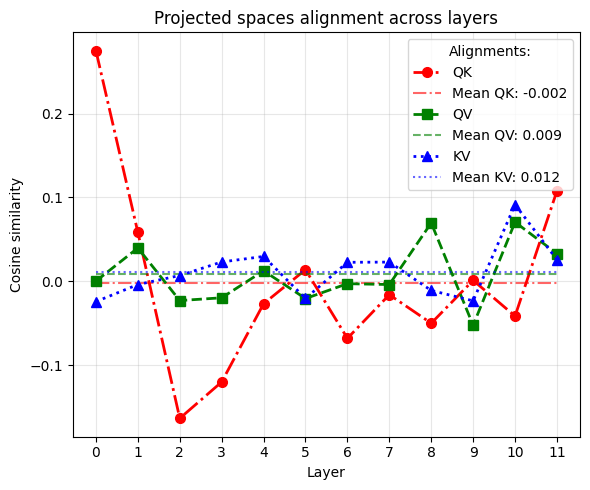

In [21]:
# Cosine similarity plot
layers = sorted(results.keys())
qk_alignment = [results[layer]['QK_alignment'] for layer in layers]
qv_alignment = [results[layer]['QV_alignment'] for layer in layers]
kv_alignment = [results[layer]['KV_alignment'] for layer in layers]

plt.figure(figsize=(6, 5))
plt.plot(layers, qk_alignment, label="QK", color="red", marker='o', linestyle="dashdot", markersize=7, linewidth=2)
plt.hlines(np.mean(qk_alignment), layers[0], layers[-1], color="red", linestyle="dashdot", alpha=0.6, label=f"Mean QK: {np.round(np.mean(qk_alignment), 3)}")
print("Mean qk alignment:", np.mean(qk_alignment))

plt.plot(layers, qv_alignment, label="QV", color="green", marker='s', linestyle="dashed", markersize=7, linewidth=2)
plt.hlines(np.mean(qv_alignment), layers[0], layers[-1], color="green", linestyle="dashed", alpha=0.6, label=f"Mean QV: {np.round(np.mean(qv_alignment), 3)}")
print("Mean qv alignment:", np.mean(qv_alignment))

plt.plot(layers, kv_alignment, label="KV", color="blue", marker='^', linestyle="dotted", markersize=7, linewidth=2)
plt.hlines(np.mean(kv_alignment), layers[0], layers[-1], color="blue", linestyle="dotted", alpha=0.6, label=f"Mean KV: {np.round(np.mean(kv_alignment), 3)}")
print("Mean kv alignment:", np.mean(kv_alignment))


plt.title("Projected spaces alignment across layers")
plt.xlabel("Layer")
plt.ylabel("Cosine similarity")

plt.xticks(layers)
#plt.ylim(-0.5, 0.5)

plt.legend(title="Alignments:")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Mean dimQ: 5.892114381123464
Mean dimK: 5.994661674188542
Mean dimV: 6.265274763799918


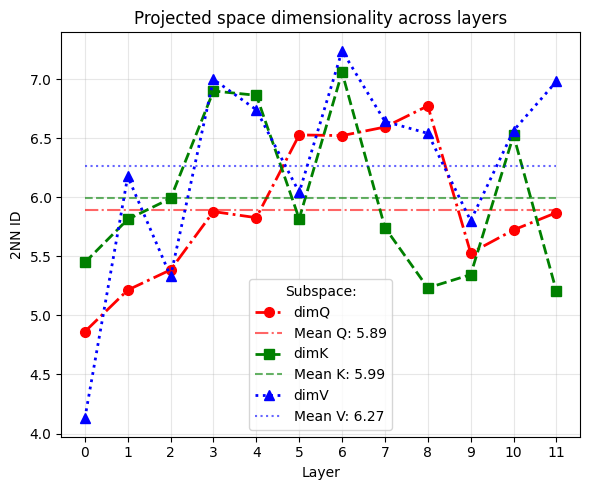

In [22]:
# 2NN intrinsic dimension plot 
layers = sorted(results.keys())
dimQ = [results[layer]['dimQ'] for layer in layers]
dimK = [results[layer]['dimK'] for layer in layers]
dimV = [results[layer]['dimV'] for layer in layers]

plt.figure(figsize=(6, 5))

plt.plot(layers, dimQ, label="dimQ", color="red", marker='o', linestyle="dashdot", markersize=7, linewidth=2)
plt.hlines(np.mean(dimQ), layers[0], layers[-1], color="red", linestyle="dashdot", alpha=0.6, label=f"Mean Q: {np.round(np.mean(dimQ), 2)}")
print("Mean dimQ:", np.mean(dimQ))

plt.plot(layers, dimK, label="dimK", color="green", marker='s', linestyle="dashed", markersize=7, linewidth=2)
plt.hlines(np.mean(dimK), layers[0], layers[-1], color="green", linestyle="dashed", alpha=0.6, label=f"Mean K: {np.round(np.mean(dimK), 2)}")
print("Mean dimK:", np.mean(dimK))

plt.plot(layers, dimV, label="dimV", color="blue", marker='^', linestyle="dotted", markersize=7, linewidth=2)
plt.hlines(np.mean(dimV), layers[0], layers[-1], color="blue", linestyle="dotted", alpha=0.6, label=f"Mean V: {np.round(np.mean(dimV), 2)}")
print("Mean dimV:", np.mean(dimV))

plt.title("Projected space dimensionality across layers")
plt.xlabel("Layer")
plt.ylabel("2NN ID")

plt.xticks(layers)
# plt.ylim(0, max(max(dimQ), max(dimK), max(dimV)) + 1)

plt.legend(title="Subspace:")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
